In [1]:
import numpy as np
import pandas as pd
from utils import extract_alloy, method_four, method_two, method_five, LSTM_Vectorizer, method_one
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Convolution2DTranspose, Concatenate, LSTM, Dropout, Reshape, Softmax, Dot, Conv1D, Input, Flatten, Embedding, Bidirectional

from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler,QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold

from ml import run_all_regressors_with_transformers
import matplotlib.pyplot as plt
import math
from joblib import dump

In [6]:
dataset = pd.read_csv("final_df.csv")
dataset.head()

,bmg_alloy,paper_sno,actual_d_max
0,Ti7.0Cu60.0Zr33.0,"[1, 5, 6, 7, 9]",3.00
1,Ti7.0Cu54.0Zr33.0Ag6.0,"[1, 5, 6, 7, 9]",6.00
2,Ti7.0Cu46.4Zr35.0Ag11.6,"[1, 5, 6, 7, 9]",6.00
3,Ti6.0Cu44.2Zr35.0Ag14.7,"[1, 6]",8.00
4,Ti5.0Cu44.2Zr36.0Ag14.7,"[1, 6]",10.00


In [7]:
elements, composition = extract_alloy(np.copy(dataset["bmg_alloy"]))
init_features = method_four(elements, composition)

In [8]:
init_features.shape

(1587, 9, 200)

In [9]:
y = np.copy(dataset["actual_d_max"])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(init_features, y, test_size=0.2, random_state=42)

In [7]:
def make_bi_lstm_model():
    inp = Input(shape=(9,200))
    lstm = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(inp)
    re_lstm = Reshape((1, lstm.shape[1], lstm.shape[2]))(lstm)
    conv = Dense(1, activation="sigmoid",)(re_lstm)
    re_conv = Reshape((lstm.shape[1],))(conv)
    prob = Softmax()(re_conv)
    weighted_lstm = Dot(axes=1)([prob, lstm])
    ff = Dense(128, activation="relu")(weighted_lstm)
    drop_ff = Dropout(0.4)(ff)
    out = Dense(1, activation="relu")(drop_ff)
    return tf.keras.Model(inputs=inp, outputs=out)

In [8]:
model = make_bi_lstm_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9, 200)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 9, 256)       336896      ['input_1[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1, 9, 256)    0           ['bidirectional[0][0]']          
                                                                                                  
 dense (Dense)                  (None, 1, 9, 1)      257         ['reshape[0][0]']                
                                                                                              

In [9]:
model.compile(optimizer="adam", loss="mean_squared_error")

In [10]:
history = model.fit(X_train, y_train, verbose=1, epochs=5000, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5000
20/20 [==============================] - 7s 51ms/step - loss: 30.5569 - val_loss: 20.9462
Epoch 2/5000
20/20 [==============================] - 0s 10ms/step - loss: 23.1627 - val_loss: 17.9510
Epoch 3/5000
20/20 [==============================] - 0s 11ms/step - loss: 19.9379 - val_loss: 15.7683
Epoch 4/5000
20/20 [==============================] - 0s 10ms/step - loss: 19.0817 - val_loss: 15.2319
Epoch 5/5000
20/20 [==============================] - 0s 11ms/step - loss: 17.9857 - val_loss: 14.2334
Epoch 6/5000
20/20 [==============================] - 0s 10ms/step - loss: 17.1159 - val_loss: 13.6121
Epoch 7/5000
20/20 [==============================] - 0s 10ms/step - loss: 16.8846 - val_loss: 13.1726
Epoch 8/5000
20/20 [==============================] - 0s 10ms/step - loss: 15.9869 - val_loss: 12.5671
Epoch 9/5000
20/20 [==============================] - 0s 11ms/step - loss: 16.2034 - val_loss: 12.3672
Epoch 10/5000
20/20 [==============================] - 0s 11ms/step - los

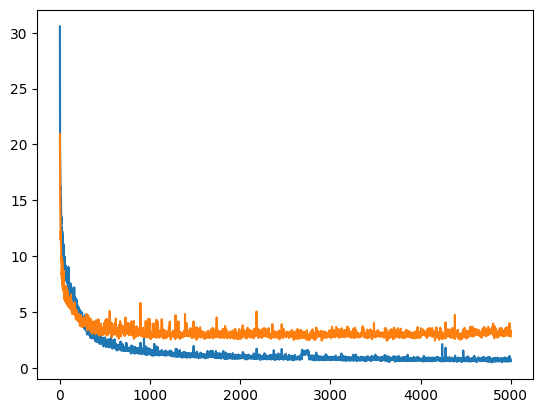

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [12]:
y_hat = model.predict(X_test)
r2_score(y_test, y_hat)

10/10 [==============================] - 1s 6ms/step


0.8712160436162726

In [10]:
model = tf.keras.models.load_model("attention_bi_lstm")

In [11]:
def get_inside(mod, layer):
    layer = mod.get_layer(layer)
    out = Flatten()(layer.output)
    return tf.keras.Model(inputs=mod.input, outputs=out)

In [12]:
feature_models = get_inside(model, "dot")

In [13]:
attention_features = feature_models.predict(init_features)

50/50 [==============================] - 14s 9ms/step


In [14]:
attention_features.shape

(1587, 256)

In [21]:
model.save("attention_bi_lstm")

INFO:tensorflow:Assets written to: attention_bi_lstm\assets


INFO:tensorflow:Assets written to: attention_bi_lstm\assets


In [15]:
X_train, X_test, y_train, y_test = train_test_split(attention_features, y, test_size=0.2, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [17]:
model_scores = run_all_regressors_with_transformers(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

  2%|▏         | 1/42 [00:03<02:03,  3.02s/it]

AdaBoostRegressor (StandardScaler) 0.7999206214210539



  7%|▋         | 3/42 [00:06<01:09,  1.78s/it]

BaggingRegressor (StandardScaler) 0.8725312390157646
BayesianRidge (StandardScaler) 0.859388730882348



 10%|▉         | 4/42 [00:07<00:50,  1.33s/it]

DecisionTreeRegressor (StandardScaler) 0.7882888267630878
DummyRegressor (StandardScaler) -9.906915659985138e-05
ElasticNet (StandardScaler) 0.39224962993192936



 17%|█▋        | 7/42 [00:07<00:20,  1.69it/s]

ElasticNetCV (StandardScaler) 0.8563591478849844
ExtraTreeRegressor (StandardScaler) 0.8143840987202544



 21%|██▏       | 9/42 [00:13<00:46,  1.40s/it]

ExtraTreesRegressor (StandardScaler) 0.8883080859953192
GammaRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:13<00:29,  1.04it/s]

GaussianProcessRegressor (StandardScaler) 0.11614832454275559



 29%|██▊       | 12/42 [00:29<01:56,  3.90s/it]

GradientBoostingRegressor (StandardScaler) 0.8719346083902777



 31%|███       | 13/42 [00:31<01:41,  3.50s/it]

HistGradientBoostingRegressor (StandardScaler) 0.8708568724260177
HuberRegressor (StandardScaler) 0.858908111533571



 40%|████      | 17/42 [00:31<00:30,  1.23s/it]

KNeighborsRegressor (StandardScaler) 0.8735223186881964
KernelRidge (StandardScaler) 0.8518325555656093
Lars (StandardScaler) -11.362807695093219



 43%|████▎     | 18/42 [00:32<00:25,  1.07s/it]

LarsCV (StandardScaler) 0.828129616574537
Lasso (StandardScaler) -9.90687678208424e-05



 48%|████▊     | 20/42 [00:32<00:16,  1.35it/s]

LassoCV (StandardScaler) 0.8560425053052236
LassoLars (StandardScaler) -9.90687678208424e-05



 52%|█████▏    | 22/42 [00:33<00:12,  1.66it/s]


LassoLarsCV (StandardScaler) 0.8560526547120499
LassoLarsIC (StandardScaler) 0.8558470510009305


 55%|█████▍    | 23/42 [00:33<00:09,  1.93it/s]

LinearRegression (StandardScaler) 0.8513784296896745



 60%|█████▉    | 25/42 [00:34<00:07,  2.31it/s]

LinearSVR (StandardScaler) 0.8402252277300192



 62%|██████▏   | 26/42 [00:34<00:07,  2.20it/s]

MLPRegressor (StandardScaler) 0.8030773281337014



 69%|██████▉   | 29/42 [00:35<00:03,  3.74it/s]

NuSVR (StandardScaler) 0.8511428822513686
OrthogonalMatchingPursuit (StandardScaler) 0.8343431449066661
OrthogonalMatchingPursuitCV (StandardScaler) 0.8343431449066661
PassiveAggressiveRegressor (StandardScaler) 0.8339139509810514
PoissonRegressor (StandardScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████▌  | 32/42 [00:37<00:05,  1.81it/s]

RANSACRegressor (StandardScaler) 0.310641725078977



 83%|████████▎ | 35/42 [01:10<00:29,  4.19s/it]

RandomForestRegressor (StandardScaler) 0.8806383452590119
Ridge (StandardScaler) 0.8518424805707123
RidgeCV (StandardScaler) 0.8547001783415584
SGDRegressor (StandardScaler) 0.847071584521053



 93%|█████████▎| 39/42 [01:10<00:05,  1.96s/it]

SVR (StandardScaler) 0.853326551867254
TransformedTargetRegressor (StandardScaler) 0.8513784296896745
TweedieRegressor (StandardScaler) 0.8731682318563552
XGBRegressor (StandardScaler) 0.857241863968022
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score -0.000000



 98%|█████████▊| 41/42 [01:12<00:01,  1.65s/it]

LGBMRegressor (StandardScaler) 0.8721276059183096
Learning rate set to 0.042513
0:	learn: 0.9732302	total: 188ms	remaining: 3m 8s
1:	learn: 0.9448284	total: 205ms	remaining: 1m 42s
2:	learn: 0.9190992	total: 221ms	remaining: 1m 13s
3:	learn: 0.8930838	total: 237ms	remaining: 59s
4:	learn: 0.8705649	total: 254ms	remaining: 50.6s
5:	learn: 0.8450170	total: 271ms	remaining: 44.8s
6:	learn: 0.8220576	total: 287ms	remaining: 40.7s
7:	learn: 0.8017370	total: 303ms	remaining: 37.6s
8:	learn: 0.7795151	total: 320ms	remaining: 35.2s
9:	learn: 0.7596302	total: 337ms	remaining: 33.4s
10:	learn: 0.7397244	total: 353ms	remaining: 31.8s
11:	learn: 0.7226849	total: 369ms	remaining: 30.4s
12:	learn: 0.7046473	total: 386ms	remaining: 29.3s
13:	learn: 0.6902164	total: 403ms	remaining: 28.4s
14:	learn: 0.6759830	total: 420ms	remaining: 27.6s
15:	learn: 0.6586359	total: 438ms	remaining: 27s
16:	learn: 0.6445291	total: 456ms	remaining: 26.4s
17:	learn: 0.6288439	total: 473ms	remaining: 25.8s
18:	learn: 0.6


 98%|█████████▊| 41/42 [01:30<00:01,  1.65s/it]

989:	learn: 0.0239004	total: 16.9s	remaining: 171ms
990:	learn: 0.0238706	total: 16.9s	remaining: 154ms
991:	learn: 0.0238511	total: 16.9s	remaining: 137ms
992:	learn: 0.0238139	total: 17s	remaining: 120ms
993:	learn: 0.0237852	total: 17s	remaining: 102ms
994:	learn: 0.0237386	total: 17s	remaining: 85.4ms
995:	learn: 0.0237185	total: 17s	remaining: 68.3ms
996:	learn: 0.0236838	total: 17s	remaining: 51.2ms
997:	learn: 0.0236479	total: 17s	remaining: 34.2ms
998:	learn: 0.0236196	total: 17.1s	remaining: 17.1ms
999:	learn: 0.0236024	total: 17.1s	remaining: 0us



 17%|█▋        | 1/6 [01:30<07:30, 90.19s/it]

CatBoostRegressor (StandardScaler) 0.8791516617963376



  2%|▏         | 1/42 [00:02<01:56,  2.85s/it]

AdaBoostRegressor (MinMaxScaler) 0.8043336650565982



  5%|▍         | 2/42 [00:05<01:57,  2.94s/it]

BaggingRegressor (MinMaxScaler) 0.8666425200954376
BayesianRidge (MinMaxScaler) 0.8587227844512266



 10%|▉         | 4/42 [00:06<00:47,  1.26s/it]

DecisionTreeRegressor (MinMaxScaler) 0.8097174794535293
DummyRegressor (MinMaxScaler) -9.906915660007343e-05
ElasticNet (MinMaxScaler) -9.906953355609538e-05



 17%|█▋        | 7/42 [00:06<00:21,  1.62it/s]

ElasticNetCV (MinMaxScaler) 0.8569309806105535
ExtraTreeRegressor (MinMaxScaler) 0.7942675866228375



 21%|██▏       | 9/42 [00:12<00:44,  1.34s/it]

ExtraTreesRegressor (MinMaxScaler) 0.8902166812774608
GammaRegressor (MinMaxScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:12<00:28,  1.07it/s]

GaussianProcessRegressor (MinMaxScaler) -2.0388378360369552



 29%|██▊       | 12/42 [00:27<01:50,  3.70s/it]

GradientBoostingRegressor (MinMaxScaler) 0.8677691376283603



 31%|███       | 13/42 [00:29<01:36,  3.32s/it]

HistGradientBoostingRegressor (MinMaxScaler) 0.8708568723110962



 40%|████      | 17/42 [00:29<00:32,  1.32s/it]

HuberRegressor (MinMaxScaler) 0.8591927585859002
KNeighborsRegressor (MinMaxScaler) 0.8772880770242862
KernelRidge (MinMaxScaler) 0.8600247571320527
Lars (MinMaxScaler) -585.2361864562807



 43%|████▎     | 18/42 [00:30<00:27,  1.15s/it]

LarsCV (MinMaxScaler) 0.6795769131305045
Lasso (MinMaxScaler) -9.906953355609538e-05



 48%|████▊     | 20/42 [00:30<00:17,  1.23it/s]

LassoCV (MinMaxScaler) 0.8566559178017646
LassoLars (MinMaxScaler) -9.906953355609538e-05



 55%|█████▍    | 23/42 [00:31<00:10,  1.78it/s]

LassoLarsCV (MinMaxScaler) 0.8566004028483396
LassoLarsIC (MinMaxScaler) 0.8548504843003897
LinearRegression (MinMaxScaler) 0.8513783530028654



 60%|█████▉    | 25/42 [00:32<00:07,  2.19it/s]

LinearSVR (MinMaxScaler) 0.8553191042411723



 62%|██████▏   | 26/42 [00:32<00:06,  2.34it/s]

MLPRegressor (MinMaxScaler) 0.7019408448684445



 69%|██████▉   | 29/42 [00:33<00:03,  3.48it/s]

NuSVR (MinMaxScaler) 0.859966955108999
OrthogonalMatchingPursuit (MinMaxScaler) 0.8261546425145015
OrthogonalMatchingPursuitCV (MinMaxScaler) 0.8261546425145015
PassiveAggressiveRegressor (MinMaxScaler) 0.8294098351767593
PoissonRegressor (MinMaxScaler) 0.1196894928117469



 76%|███████▌  | 32/42 [00:35<00:05,  1.71it/s]

RANSACRegressor (MinMaxScaler) 0.5435513004297976



 83%|████████▎ | 35/42 [01:07<00:28,  4.02s/it]

RandomForestRegressor (MinMaxScaler) 0.8835944362737521
Ridge (MinMaxScaler) 0.8602116209019885
RidgeCV (MinMaxScaler) 0.8602116350362865
SGDRegressor (MinMaxScaler) 0.8677574559938227
SVR (MinMaxScaler) 0.7739701173758481
TransformedTargetRegressor (MinMaxScaler) 0.8513783530028654



 90%|█████████ | 38/42 [01:07<00:09,  2.34s/it]

TweedieRegressor (MinMaxScaler) 0.5646983977349851



 95%|█████████▌| 40/42 [01:08<00:03,  1.91s/it]

XGBRegressor (MinMaxScaler) 0.8576441508594819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score 0.100092
LGBMRegressor (MinMaxScaler) 0.8769930251612974
Learning rate set to 0.042513
0:	learn: 0.1412469	total: 18.8ms	remaining: 18.8s
1:	learn: 0.1371249	total: 35.9ms	remaining: 17.9s
2:	learn: 0.1333907	total: 52.7ms	remaining: 17.5s
3:	learn: 0.1296151	total: 70ms	remaining: 17.4s
4:	learn: 0.1263469	total: 87.2ms	remaining: 17.3s
5:	learn: 0.1226390	total: 104ms	remaining: 17.2s
6:	learn: 0.1193069	total: 121ms	remaining: 17.2s
7:	learn: 0.1163577	total: 138ms	remaining: 17.1s
8:	learn: 0.1131326	total: 155ms	remaining: 17.1s
9:	learn: 0.1102467	total: 172ms	remaining: 17s
10:	learn: 0.1073577	total: 190


 95%|█████████▌| 40/42 [01:19<00:03,  1.91s/it]

493:	learn: 0.0080481	total: 10.3s	remaining: 10.5s
494:	learn: 0.0080334	total: 10.3s	remaining: 10.5s
495:	learn: 0.0080077	total: 10.3s	remaining: 10.5s
496:	learn: 0.0079841	total: 10.3s	remaining: 10.4s
497:	learn: 0.0079697	total: 10.3s	remaining: 10.4s
498:	learn: 0.0079625	total: 10.4s	remaining: 10.4s
499:	learn: 0.0079464	total: 10.4s	remaining: 10.4s
500:	learn: 0.0079283	total: 10.4s	remaining: 10.4s
501:	learn: 0.0079127	total: 10.4s	remaining: 10.3s
502:	learn: 0.0078966	total: 10.5s	remaining: 10.3s
503:	learn: 0.0078827	total: 10.5s	remaining: 10.3s
504:	learn: 0.0078713	total: 10.5s	remaining: 10.3s
505:	learn: 0.0078501	total: 10.5s	remaining: 10.3s
506:	learn: 0.0078313	total: 10.5s	remaining: 10.3s
507:	learn: 0.0078241	total: 10.6s	remaining: 10.2s
508:	learn: 0.0078053	total: 10.6s	remaining: 10.2s
509:	learn: 0.0077803	total: 10.6s	remaining: 10.2s
510:	learn: 0.0077662	total: 10.7s	remaining: 10.2s
511:	learn: 0.0077516	total: 10.7s	remaining: 10.2s
512:	learn: 


 33%|███▎      | 2/6 [03:00<06:01, 90.33s/it]

998:	learn: 0.0034951	total: 20.6s	remaining: 20.6ms
999:	learn: 0.0034897	total: 20.6s	remaining: 0us
CatBoostRegressor (MinMaxScaler) 0.881610875343082



  2%|▏         | 1/42 [00:03<02:12,  3.22s/it]

AdaBoostRegressor (MaxAbsScaler) 0.8033019630027726



  5%|▍         | 2/42 [00:06<02:02,  3.06s/it]

BaggingRegressor (MaxAbsScaler) 0.8855870888587093
BayesianRidge (MaxAbsScaler) 0.8579522183151373



 10%|▉         | 4/42 [00:06<00:49,  1.30s/it]

DecisionTreeRegressor (MaxAbsScaler) 0.7873199933058912
DummyRegressor (MaxAbsScaler) -9.906915660007343e-05
ElasticNet (MaxAbsScaler) -9.906953355609538e-05



 17%|█▋        | 7/42 [00:07<00:22,  1.55it/s]

ElasticNetCV (MaxAbsScaler) 0.8564519694302936
ExtraTreeRegressor (MaxAbsScaler) 0.7610839689954298



 21%|██▏       | 9/42 [00:12<00:44,  1.33s/it]

ExtraTreesRegressor (MaxAbsScaler) 0.8892082967312327
GammaRegressor (MaxAbsScaler) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:12<00:28,  1.08it/s]

GaussianProcessRegressor (MaxAbsScaler) 0.1862397689472528



 29%|██▊       | 12/42 [00:27<01:48,  3.61s/it]

GradientBoostingRegressor (MaxAbsScaler) 0.8681094347845891



 31%|███       | 13/42 [00:29<01:34,  3.27s/it]

HistGradientBoostingRegressor (MaxAbsScaler) 0.8708568723110962
HuberRegressor (MaxAbsScaler) 0.8570509485126878



 40%|████      | 17/42 [00:29<00:32,  1.29s/it]

KNeighborsRegressor (MaxAbsScaler) 0.8740802655378797
KernelRidge (MaxAbsScaler) 0.8571642428688131
Lars (MaxAbsScaler) -146.35548718093054



 43%|████▎     | 18/42 [00:30<00:27,  1.13s/it]

LarsCV (MaxAbsScaler) 0.6323901461756742
Lasso (MaxAbsScaler) -9.906953355609538e-05



 48%|████▊     | 20/42 [00:30<00:17,  1.23it/s]

LassoCV (MaxAbsScaler) 0.8563117655641296
LassoLars (MaxAbsScaler) -9.906953355609538e-05



 55%|█████▍    | 23/42 [00:31<00:10,  1.79it/s]

LassoLarsCV (MaxAbsScaler) 0.8562824012364298
LassoLarsIC (MaxAbsScaler) 0.8542771472611461
LinearRegression (MaxAbsScaler) 0.8513785537246505



 62%|██████▏   | 26/42 [00:32<00:06,  2.55it/s]

LinearSVR (MaxAbsScaler) 0.853751384817113
MLPRegressor (MaxAbsScaler) 0.6956553465789037



 69%|██████▉   | 29/42 [00:32<00:03,  3.76it/s]

NuSVR (MaxAbsScaler) 0.8581406164627217
OrthogonalMatchingPursuit (MaxAbsScaler) 0.8367227891321932
OrthogonalMatchingPursuitCV (MaxAbsScaler) 0.8367227891321932
PassiveAggressiveRegressor (MaxAbsScaler) 0.8003871303429319
PoissonRegressor (MaxAbsScaler) 0.27476940332029487



 76%|███████▌  | 32/42 [00:35<00:05,  1.78it/s]

RANSACRegressor (MaxAbsScaler) 0.7122418869748091



 86%|████████▌ | 36/42 [01:05<00:19,  3.29s/it]

RandomForestRegressor (MaxAbsScaler) 0.880377487785543
Ridge (MaxAbsScaler) 0.8558452602512558
RidgeCV (MaxAbsScaler) 0.8558454761980443
SGDRegressor (MaxAbsScaler) 0.8674933849782117
SVR (MaxAbsScaler) 0.7589161377697723



 93%|█████████▎| 39/42 [01:05<00:06,  2.05s/it]

TransformedTargetRegressor (MaxAbsScaler) 0.8513785537246505
TweedieRegressor (MaxAbsScaler) 0.7436240046078417
XGBRegressor (MaxAbsScaler) 0.8576441508594819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65279
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score 0.100092



 98%|█████████▊| 41/42 [01:07<00:01,  1.71s/it]

LGBMRegressor (MaxAbsScaler) 0.8708433845885744
Learning rate set to 0.042513
0:	learn: 0.1412469	total: 20ms	remaining: 19.9s
1:	learn: 0.1371249	total: 39.5ms	remaining: 19.7s
2:	learn: 0.1333907	total: 57.1ms	remaining: 19s
3:	learn: 0.1296151	total: 74.3ms	remaining: 18.5s
4:	learn: 0.1263469	total: 92.2ms	remaining: 18.3s
5:	learn: 0.1226390	total: 108ms	remaining: 18s
6:	learn: 0.1193069	total: 125ms	remaining: 17.7s
7:	learn: 0.1163577	total: 141ms	remaining: 17.4s
8:	learn: 0.1131326	total: 157ms	remaining: 17.3s
9:	learn: 0.1102467	total: 174ms	remaining: 17.2s
10:	learn: 0.1073577	total: 191ms	remaining: 17.2s
11:	learn: 0.1048847	total: 208ms	remaining: 17.2s
12:	learn: 0.1022669	total: 227ms	remaining: 17.2s
13:	learn: 0.1001725	total: 245ms	remaining: 17.2s
14:	learn: 0.0981068	total: 263ms	remaining: 17.3s
15:	learn: 0.0955892	total: 280ms	remaining: 17.2s
16:	learn: 0.0935418	total: 298ms	remaining: 17.2s
17:	learn: 0.0912654	total: 317ms	remaining: 17.3s
18:	learn: 0.08


 98%|█████████▊| 41/42 [01:19<00:01,  1.71s/it]

672:	learn: 0.0056723	total: 12.2s	remaining: 5.92s
673:	learn: 0.0056599	total: 12.2s	remaining: 5.91s
674:	learn: 0.0056479	total: 12.2s	remaining: 5.89s
675:	learn: 0.0056359	total: 12.2s	remaining: 5.87s
676:	learn: 0.0056270	total: 12.3s	remaining: 5.85s
677:	learn: 0.0056148	total: 12.3s	remaining: 5.83s
678:	learn: 0.0056050	total: 12.3s	remaining: 5.82s
679:	learn: 0.0055970	total: 12.3s	remaining: 5.8s
680:	learn: 0.0055869	total: 12.3s	remaining: 5.78s
681:	learn: 0.0055776	total: 12.4s	remaining: 5.77s
682:	learn: 0.0055654	total: 12.4s	remaining: 5.75s
683:	learn: 0.0055559	total: 12.4s	remaining: 5.73s
684:	learn: 0.0055450	total: 12.4s	remaining: 5.71s
685:	learn: 0.0055359	total: 12.4s	remaining: 5.7s
686:	learn: 0.0055268	total: 12.5s	remaining: 5.68s
687:	learn: 0.0055158	total: 12.5s	remaining: 5.66s
688:	learn: 0.0055078	total: 12.5s	remaining: 5.64s
689:	learn: 0.0054982	total: 12.5s	remaining: 5.62s
690:	learn: 0.0054879	total: 12.5s	remaining: 5.61s
691:	learn: 0.


 50%|█████     | 3/6 [04:26<04:24, 88.21s/it]

996:	learn: 0.0034373	total: 18.1s	remaining: 54.6ms
997:	learn: 0.0034321	total: 18.2s	remaining: 36.4ms
998:	learn: 0.0034280	total: 18.2s	remaining: 18.2ms
999:	learn: 0.0034255	total: 18.2s	remaining: 0us
CatBoostRegressor (MaxAbsScaler) 0.8791516590387428



  2%|▏         | 1/42 [00:02<01:40,  2.46s/it]

AdaBoostRegressor (Normalizer) 0.9464704681508276



  5%|▍         | 2/42 [00:04<01:19,  2.00s/it]

BaggingRegressor (Normalizer) 0.8825471698113208
BayesianRidge (Normalizer) 0.892060009729855



 10%|▉         | 4/42 [00:04<00:32,  1.18it/s]

DecisionTreeRegressor (Normalizer) 0.8584905660377359
DummyRegressor (Normalizer) 0.0
ElasticNet (Normalizer) -1.7763568394002505e-15



 17%|█▋        | 7/42 [00:04<00:14,  2.39it/s]

ElasticNetCV (Normalizer) 0.8910668795995493
ExtraTreeRegressor (Normalizer) 0.8726415094339622



 21%|██▏       | 9/42 [00:06<00:16,  1.98it/s]

ExtraTreesRegressor (Normalizer) 0.9493339622641509
GammaRegressor (Normalizer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:06<00:11,  2.66it/s]

GaussianProcessRegressor (Normalizer) 0.9421979976872333



 29%|██▊       | 12/42 [00:21<01:37,  3.26s/it]

GradientBoostingRegressor (Normalizer) 0.8988244009128786



 31%|███       | 13/42 [00:23<01:27,  3.01s/it]

HistGradientBoostingRegressor (Normalizer) 0.9246260604474633
HuberRegressor (Normalizer) 0.8949301789707418



 40%|████      | 17/42 [00:24<00:29,  1.19s/it]

KNeighborsRegressor (Normalizer) 0.9145283018867925
KernelRidge (Normalizer) 0.8632345860435252
Lars (Normalizer) 0.6519784570997385



 43%|████▎     | 18/42 [00:24<00:25,  1.05s/it]

LarsCV (Normalizer) 0.8283956086379191
Lasso (Normalizer) -1.7763568394002505e-15



 48%|████▊     | 20/42 [00:24<00:15,  1.38it/s]

LassoCV (Normalizer) 0.8898430632410428
LassoLars (Normalizer) -1.7763568394002505e-15



 55%|█████▍    | 23/42 [00:25<00:09,  1.98it/s]

LassoLarsCV (Normalizer) 0.8898173221666522
LassoLarsIC (Normalizer) 0.8893455866088069



 60%|█████▉    | 25/42 [00:25<00:06,  2.80it/s]

LinearRegression (Normalizer) 0.8870824986810002
LinearSVR (Normalizer) 0.8850009328829198



 62%|██████▏   | 26/42 [00:26<00:06,  2.62it/s]

MLPRegressor (Normalizer) 0.9312850387855561



 69%|██████▉   | 29/42 [00:26<00:03,  3.60it/s]

NuSVR (Normalizer) 0.951787893391498
OrthogonalMatchingPursuit (Normalizer) 0.8262260968295909
OrthogonalMatchingPursuitCV (Normalizer) 0.8262260968295909
PassiveAggressiveRegressor (Normalizer) -0.7654579913592796
PoissonRegressor (Normalizer) 0.08948018067996455



 76%|███████▌  | 32/42 [00:29<00:05,  1.78it/s]

RANSACRegressor (Normalizer) 0.677436371498803



 83%|████████▎ | 35/42 [00:46<00:16,  2.32s/it]

RandomForestRegressor (Normalizer) 0.9097084905660378
Ridge (Normalizer) 0.8736411686981417
RidgeCV (Normalizer) 0.8945365336099129
SGDRegressor (Normalizer) 0.7549109694703813
SVR (Normalizer) 0.9307994330826604



 90%|█████████ | 38/42 [00:46<00:05,  1.36s/it]

TransformedTargetRegressor (Normalizer) 0.8870824986810002
TweedieRegressor (Normalizer) 0.1290714846923866



 95%|█████████▌| 40/42 [00:47<00:02,  1.09s/it]

XGBRegressor (Normalizer) 0.8772919210915819
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65279
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score 0.666667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBMRegressor (Normalizer) 0.9221221233458204
Learning rate set to 0.042513
0:	learn: 0.4553793	total: 17.5ms	remaining: 17.5s
1:	learn: 0.4393638	total: 34ms	remaining: 17s
2:	learn: 0.4250249	total: 50ms	remaining: 16.6s
3:	learn: 0.4111705	total: 65.9ms	remaining: 16.4s
4:	learn: 0.3979411	total: 82.3ms	remaining: 16.4s
5:	learn: 0.3857206	total: 98.4ms	remaining: 16.3s
6:	learn: 0


 95%|█████████▌| 40/42 [01:03<00:02,  1.09s/it]

848:	learn: 0.0109034	total: 15.5s	remaining: 2.75s
849:	learn: 0.0108790	total: 15.5s	remaining: 2.73s
850:	learn: 0.0108532	total: 15.5s	remaining: 2.71s
851:	learn: 0.0108443	total: 15.5s	remaining: 2.69s
852:	learn: 0.0108327	total: 15.5s	remaining: 2.68s
853:	learn: 0.0108226	total: 15.6s	remaining: 2.66s
854:	learn: 0.0107941	total: 15.6s	remaining: 2.64s
855:	learn: 0.0107741	total: 15.6s	remaining: 2.62s
856:	learn: 0.0107610	total: 15.6s	remaining: 2.6s
857:	learn: 0.0107480	total: 15.6s	remaining: 2.58s
858:	learn: 0.0107207	total: 15.6s	remaining: 2.57s
859:	learn: 0.0106893	total: 15.7s	remaining: 2.55s
860:	learn: 0.0106713	total: 15.7s	remaining: 2.53s
861:	learn: 0.0106534	total: 15.7s	remaining: 2.51s
862:	learn: 0.0106173	total: 15.7s	remaining: 2.49s
863:	learn: 0.0105974	total: 15.7s	remaining: 2.48s
864:	learn: 0.0105747	total: 15.7s	remaining: 2.46s
865:	learn: 0.0105701	total: 15.8s	remaining: 2.44s
866:	learn: 0.0105512	total: 15.8s	remaining: 2.42s
867:	learn: 0


 67%|██████▋   | 4/6 [05:32<02:39, 79.69s/it]

998:	learn: 0.0082437	total: 18.2s	remaining: 18.2ms
999:	learn: 0.0082369	total: 18.2s	remaining: 0us
CatBoostRegressor (Normalizer) 0.9478188828972567



  2%|▏         | 1/42 [00:03<02:33,  3.74s/it]

AdaBoostRegressor (QuantileTransformer) 0.8893931899301114



  5%|▍         | 2/42 [00:06<02:07,  3.20s/it]

BaggingRegressor (QuantileTransformer) 0.9151520925583165



  7%|▋         | 3/42 [00:06<01:14,  1.90s/it]

BayesianRidge (QuantileTransformer) 0.9094604914356202



 10%|▉         | 4/42 [00:07<00:53,  1.40s/it]

DecisionTreeRegressor (QuantileTransformer) 0.8834329797596554



 12%|█▏        | 5/42 [00:07<00:37,  1.00s/it]

DummyRegressor (QuantileTransformer) -0.00015940296210747995



 14%|█▍        | 6/42 [00:08<00:27,  1.32it/s]

ElasticNet (QuantileTransformer) -0.000159405245016897



 17%|█▋        | 7/42 [00:08<00:24,  1.43it/s]

ElasticNetCV (QuantileTransformer) 0.908998150333836



 19%|█▉        | 8/42 [00:09<00:19,  1.72it/s]

ExtraTreeRegressor (QuantileTransformer) 0.8594454263972725



 21%|██▏       | 9/42 [00:14<01:11,  2.16s/it]

ExtraTreesRegressor (QuantileTransformer) 0.943232163390767



 24%|██▍       | 10/42 [00:14<00:50,  1.58s/it]

GammaRegressor (QuantileTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:15<00:38,  1.25s/it]

GaussianProcessRegressor (QuantileTransformer) -0.35513020468310574



 29%|██▊       | 12/42 [00:30<02:41,  5.37s/it]

GradientBoostingRegressor (QuantileTransformer) 0.9278451726651576



 31%|███       | 13/42 [00:32<02:09,  4.46s/it]

HistGradientBoostingRegressor (QuantileTransformer) 0.9261993190749571



 33%|███▎      | 14/42 [00:33<01:31,  3.26s/it]

HuberRegressor (QuantileTransformer) 0.8971640809765581



 36%|███▌      | 15/42 [00:33<01:03,  2.36s/it]

KNeighborsRegressor (QuantileTransformer) 0.9313606342215127



 38%|███▊      | 16/42 [00:33<00:45,  1.75s/it]

KernelRidge (QuantileTransformer) 0.9039617791568263



 40%|████      | 17/42 [00:34<00:33,  1.33s/it]

Lars (QuantileTransformer) -0.764444864415188



 43%|████▎     | 18/42 [00:34<00:27,  1.13s/it]

LarsCV (QuantileTransformer) 0.8702596517444698



 45%|████▌     | 19/42 [00:35<00:20,  1.14it/s]

Lasso (QuantileTransformer) -0.000159405245016897



 48%|████▊     | 20/42 [00:35<00:17,  1.27it/s]

LassoCV (QuantileTransformer) 0.9087456649993633



 50%|█████     | 21/42 [00:35<00:13,  1.57it/s]

LassoLars (QuantileTransformer) -0.000159405245016897



 52%|█████▏    | 22/42 [00:36<00:13,  1.45it/s]

LassoLarsCV (QuantileTransformer) 0.908785386913901



 55%|█████▍    | 23/42 [00:37<00:11,  1.64it/s]

LassoLarsIC (QuantileTransformer) 0.9079087870841773



 57%|█████▋    | 24/42 [00:37<00:09,  1.90it/s]

LinearRegression (QuantileTransformer) 0.9042406945470917



 60%|█████▉    | 25/42 [00:38<00:09,  1.73it/s]

LinearSVR (QuantileTransformer) 0.8862666035452432



 62%|██████▏   | 26/42 [00:39<00:10,  1.49it/s]

MLPRegressor (QuantileTransformer) 0.9046102312966381



 64%|██████▍   | 27/42 [00:39<00:10,  1.47it/s]

NuSVR (QuantileTransformer) 0.9349797102418842



 67%|██████▋   | 28/42 [00:40<00:07,  1.79it/s]

OrthogonalMatchingPursuit (QuantileTransformer) 0.8690261900482763



 69%|██████▉   | 29/42 [00:40<00:06,  2.00it/s]

OrthogonalMatchingPursuitCV (QuantileTransformer) 0.8659918095198974



 71%|███████▏  | 30/42 [00:40<00:05,  2.29it/s]

PassiveAggressiveRegressor (QuantileTransformer) 0.8989609708746411



 74%|███████▍  | 31/42 [00:40<00:04,  2.49it/s]

PoissonRegressor (QuantileTransformer) 0.6409755580235821



 76%|███████▌  | 32/42 [00:43<00:11,  1.17s/it]

RANSACRegressor (QuantileTransformer) 0.8509030883801773



 79%|███████▊  | 33/42 [01:09<01:16,  8.52s/it]

RandomForestRegressor (QuantileTransformer) 0.9320833522050228



 81%|████████  | 34/42 [01:09<00:48,  6.05s/it]

Ridge (QuantileTransformer) 0.9066641907355809



 83%|████████▎ | 35/42 [01:10<00:30,  4.34s/it]

RidgeCV (QuantileTransformer) 0.9099931876232041



 86%|████████▌ | 36/42 [01:10<00:18,  3.12s/it]

SGDRegressor (QuantileTransformer) 0.901066074719779



 88%|████████▊ | 37/42 [01:10<00:11,  2.28s/it]

SVR (QuantileTransformer) 0.9200856254081753



 90%|█████████ | 38/42 [01:11<00:06,  1.70s/it]

TransformedTargetRegressor (QuantileTransformer) 0.9042406945470917



 93%|█████████▎| 39/42 [01:11<00:03,  1.28s/it]

TweedieRegressor (QuantileTransformer) 0.7953917290577054



 95%|█████████▌| 40/42 [01:13<00:02,  1.38s/it]

XGBRegressor (QuantileTransformer) 0.9203149149468068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65280
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score 0.444465



 98%|█████████▊| 41/42 [01:13<00:01,  1.18s/it]

LGBMRegressor (QuantileTransformer) 0.9279126737743073
Learning rate set to 0.042513
0:	learn: 0.3405168	total: 18.6ms	remaining: 18.5s
1:	learn: 0.3297437	total: 35.6ms	remaining: 17.8s
2:	learn: 0.3201428	total: 51.7ms	remaining: 17.2s
3:	learn: 0.3104775	total: 68.1ms	remaining: 16.9s
4:	learn: 0.3007104	total: 84.6ms	remaining: 16.8s
5:	learn: 0.2914248	total: 101ms	remaining: 16.7s
6:	learn: 0.2830930	total: 117ms	remaining: 16.6s
7:	learn: 0.2745040	total: 134ms	remaining: 16.6s
8:	learn: 0.2662581	total: 150ms	remaining: 16.5s
9:	learn: 0.2586095	total: 166ms	remaining: 16.5s
10:	learn: 0.2513967	total: 183ms	remaining: 16.4s
11:	learn: 0.2450796	total: 200ms	remaining: 16.4s
12:	learn: 0.2382417	total: 217ms	remaining: 16.5s
13:	learn: 0.2312523	total: 235ms	remaining: 16.5s
14:	learn: 0.2249662	total: 252ms	remaining: 16.6s
15:	learn: 0.2187453	total: 271ms	remaining: 16.7s
16:	learn: 0.2128902	total: 289ms	remaining: 16.7s
17:	learn: 0.2075319	total: 308ms	remaining: 16.8s
18


 83%|████████▎ | 5/6 [07:06<01:24, 84.76s/it]

997:	learn: 0.0106760	total: 19.2s	remaining: 38.5ms
998:	learn: 0.0106487	total: 19.2s	remaining: 19.3ms
999:	learn: 0.0106276	total: 19.3s	remaining: 0us
CatBoostRegressor (QuantileTransformer) 0.9379264244756018



  2%|▏         | 1/42 [00:04<03:08,  4.60s/it]

AdaBoostRegressor (PowerTransformer) 0.8843923297737893



  5%|▍         | 2/42 [00:08<02:36,  3.90s/it]

BaggingRegressor (PowerTransformer) 0.9121346956872707



  7%|▋         | 3/42 [00:08<01:38,  2.52s/it]

BayesianRidge (PowerTransformer) 0.9011853677305166



 10%|▉         | 4/42 [00:10<01:16,  2.00s/it]

DecisionTreeRegressor (PowerTransformer) 0.8407689342528394



 12%|█▏        | 5/42 [00:10<00:58,  1.58s/it]

DummyRegressor (PowerTransformer) -0.00017038207232711322



 14%|█▍        | 6/42 [00:11<00:47,  1.32s/it]

ElasticNet (PowerTransformer) 0.33745385229202596



 17%|█▋        | 7/42 [00:12<00:44,  1.27s/it]

ElasticNetCV (PowerTransformer) 0.9035619893187827



 19%|█▉        | 8/42 [00:13<00:38,  1.14s/it]

ExtraTreeRegressor (PowerTransformer) 0.8280911394028488



 21%|██▏       | 9/42 [00:19<01:26,  2.63s/it]

ExtraTreesRegressor (PowerTransformer) 0.9353420935712932



 24%|██▍       | 10/42 [00:20<01:06,  2.08s/it]

GammaRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.



 26%|██▌       | 11/42 [00:21<00:54,  1.76s/it]

GaussianProcessRegressor (PowerTransformer) 0.1585903407672843



 29%|██▊       | 12/42 [00:37<03:02,  6.10s/it]

GradientBoostingRegressor (PowerTransformer) 0.910457538904278



 31%|███       | 13/42 [00:40<02:29,  5.16s/it]

HistGradientBoostingRegressor (PowerTransformer) 0.9150464556537508



 33%|███▎      | 14/42 [00:41<01:49,  3.90s/it]

HuberRegressor (PowerTransformer) 0.8934320591083929



 36%|███▌      | 15/42 [00:42<01:20,  2.97s/it]

KNeighborsRegressor (PowerTransformer) 0.9074969999650505



 38%|███▊      | 16/42 [00:43<01:00,  2.33s/it]

KernelRidge (PowerTransformer) 0.898505420447399



 40%|████      | 17/42 [00:44<00:47,  1.90s/it]

Lars (PowerTransformer) -15.814198925354116



 43%|████▎     | 18/42 [00:45<00:40,  1.70s/it]

LarsCV (PowerTransformer) 0.7856798985797241



 45%|████▌     | 19/42 [00:46<00:32,  1.43s/it]

Lasso (PowerTransformer) -0.00017038203310448807



 48%|████▊     | 20/42 [00:47<00:29,  1.34s/it]

LassoCV (PowerTransformer) 0.9033637713144549



 50%|█████     | 21/42 [00:48<00:24,  1.18s/it]

LassoLars (PowerTransformer) -0.00017038203310448807



 52%|█████▏    | 22/42 [00:49<00:24,  1.24s/it]

LassoLarsCV (PowerTransformer) 0.903476962460055



 55%|█████▍    | 23/42 [00:50<00:21,  1.15s/it]

LassoLarsIC (PowerTransformer) 0.9032037042683843



 57%|█████▋    | 24/42 [00:51<00:19,  1.07s/it]

LinearRegression (PowerTransformer) 0.8982626808913836



 60%|█████▉    | 25/42 [00:52<00:19,  1.12s/it]

LinearSVR (PowerTransformer) 0.8864598190464368



 62%|██████▏   | 26/42 [00:53<00:18,  1.16s/it]

MLPRegressor (PowerTransformer) 0.8870132181342346



 64%|██████▍   | 27/42 [00:54<00:16,  1.13s/it]

NuSVR (PowerTransformer) 0.922837275935274



 67%|██████▋   | 28/42 [00:55<00:14,  1.04s/it]

OrthogonalMatchingPursuit (PowerTransformer) 0.8846114093585846



 69%|██████▉   | 29/42 [00:56<00:12,  1.00it/s]

OrthogonalMatchingPursuitCV (PowerTransformer) 0.8846114093585846



 71%|███████▏  | 30/42 [00:57<00:11,  1.06it/s]

PassiveAggressiveRegressor (PowerTransformer) 0.8866561277840443



 74%|███████▍  | 31/42 [00:58<00:09,  1.10it/s]

PoissonRegressor (PowerTransformer) model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.



 76%|███████▌  | 32/42 [01:01<00:17,  1.70s/it]

RANSACRegressor (PowerTransformer) 0.7636071461653698



 79%|███████▊  | 33/42 [01:28<01:23,  9.29s/it]

RandomForestRegressor (PowerTransformer) 0.9080850585242393



 81%|████████  | 34/42 [01:29<00:53,  6.75s/it]

Ridge (PowerTransformer) 0.8985030032565129



 83%|████████▎ | 35/42 [01:30<00:34,  4.99s/it]

RidgeCV (PowerTransformer) 0.8998588244526049



 86%|████████▌ | 36/42 [01:31<00:22,  3.74s/it]

SGDRegressor (PowerTransformer) 0.896133072970282



 88%|████████▊ | 37/42 [01:32<00:14,  2.89s/it]

SVR (PowerTransformer) 0.9222404802531735



 90%|█████████ | 38/42 [01:33<00:09,  2.28s/it]

TransformedTargetRegressor (PowerTransformer) 0.8982626808913836



 93%|█████████▎| 39/42 [01:33<00:05,  1.85s/it]

TweedieRegressor (PowerTransformer) 0.886894996018455



 95%|█████████▌| 40/42 [01:36<00:03,  1.98s/it]

XGBRegressor (PowerTransformer) 0.9052843398686512
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65236
[LightGBM] [Info] Number of data points in the train set: 1269, number of used features: 256
[LightGBM] [Info] Start training from score 0.000000



 98%|█████████▊| 41/42 [01:37<00:01,  1.80s/it]

LGBMRegressor (PowerTransformer) 0.9125948698845615
Learning rate set to 0.042513
0:	learn: 0.9701662	total: 17.5ms	remaining: 17.4s
1:	learn: 0.9425370	total: 35.1ms	remaining: 17.5s
2:	learn: 0.9163288	total: 52.3ms	remaining: 17.4s
3:	learn: 0.8895316	total: 69.9ms	remaining: 17.4s
4:	learn: 0.8622977	total: 86ms	remaining: 17.1s
5:	learn: 0.8366607	total: 102ms	remaining: 17s
6:	learn: 0.8132924	total: 120ms	remaining: 17s
7:	learn: 0.7886387	total: 137ms	remaining: 17s
8:	learn: 0.7656180	total: 155ms	remaining: 17s
9:	learn: 0.7432928	total: 171ms	remaining: 17s
10:	learn: 0.7251457	total: 188ms	remaining: 16.9s
11:	learn: 0.7069905	total: 207ms	remaining: 17.1s
12:	learn: 0.6874628	total: 226ms	remaining: 17.2s
13:	learn: 0.6685735	total: 246ms	remaining: 17.3s
14:	learn: 0.6512456	total: 264ms	remaining: 17.3s
15:	learn: 0.6336098	total: 283ms	remaining: 17.4s
16:	learn: 0.6158615	total: 303ms	remaining: 17.5s
17:	learn: 0.6000507	total: 323ms	remaining: 17.6s
18:	learn: 0.5856


100%|██████████| 6/6 [09:04<00:00, 90.73s/it]

995:	learn: 0.0315863	total: 18.8s	remaining: 75.7ms
996:	learn: 0.0315370	total: 18.9s	remaining: 56.7ms
997:	learn: 0.0314967	total: 18.9s	remaining: 37.8ms
998:	learn: 0.0314472	total: 18.9s	remaining: 18.9ms
999:	learn: 0.0314010	total: 18.9s	remaining: 0us
CatBoostRegressor (PowerTransformer) 0.9284210327459334


In [18]:
model_scores

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,Model Params
Model,,,,,
NuSVR (Normalizer),0.75,0.95,0.10,0.56,"{'memory': None, 'steps': [('classifier', NuSV..."
ExtraTreesRegressor (Normalizer),0.74,0.95,0.11,1.30,"{'memory': None, 'steps': [('classifier', Extr..."
CatBoostRegressor (Normalizer),0.73,0.95,0.11,18.56,"{'memory': None, 'steps': [('classifier', <cat..."
AdaBoostRegressor (Normalizer),0.72,0.95,0.11,2.46,"{'memory': None, 'steps': [('classifier', AdaB..."
ExtraTreesRegressor (QuantileTransformer),0.70,0.94,0.08,5.64,"{'memory': None, 'steps': [('classifier', Extr..."
...,...,...,...,...,...
GaussianProcessRegressor (MinMaxScaler),-14.79,-2.04,0.23,0.23,"{'memory': None, 'steps': [('classifier', Gaus..."
Lars (StandardScaler),-63.25,-11.36,3.25,0.11,"{'memory': None, 'steps': [('classifier', Lars..."
Lars (PowerTransformer),-86.38,-15.81,4.10,0.88,"{'memory': None, 'steps': [('classifier', Lars..."


In [12]:
quantx = QuantileTransformer()
quanty = QuantileTransformer()
trans_features = quantx.fit_transform(attention_features)
trans_y = quanty.fit_transform(y.reshape((dataset.actual_d_max.shape[0], 1)))

In [13]:
x1, x2, y1, y2 = train_test_split(trans_features, trans_y, random_state=42, test_size=0.2)
extree = ExtraTreesRegressor()
extree.fit(x1, y1)
extree.score(x2, y2)

0.943339328739719

In [14]:
dump(quantx, "X_QuantileTransformer.bin")
dump(quanty, "Y_QuantileTransformer.bin")

['Y_QuantileTransformer.bin']

In [15]:
dump(extree, "ExtraTreeRegressor.bin")

['ExtraTreeRegressor.bin']

In [19]:
X = trans_features
y = trans_y

In [20]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred_total = []
y_test_total = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    cb = ExtraTreesRegressor(verbose=0)
    y_pred = cb.fit(X_train, y_train).predict(X_test)

    y_pred_total.append(y_pred)
    y_test_total.append(y_test)

y_pred_total = np.array([item for sublist in y_pred_total for item in sublist])
y_test_total = np.array([item for sublist in y_test_total for item in sublist])
print(f"R2 Score: {r2_score(y_test_total, y_pred_total)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test_total, y_pred_total))}")

R2 Score: 0.9569715071743922
RMSE: 0.07284755148377413
